## Neuroevolution using EvoTorch

#### Imports

In [1]:
import torch
import numpy as np
import math
import pandas as pd

from evotorch.tools import dtype_of, device_of
from evotorch.neuroevolution import NEProblem
from evotorch.algorithms import PGPE, SNES, XNES, CMAES
from evotorch.logging import PandasLogger, StdOutLogger

from Trainer import Trainer
from Model import Complex_CA
from State_Generator import Generator, State

In [2]:
#hw = 'mps:0' if torch.backends.mps.is_available() else 'cpu'
#hw = 'cuda'
hw = 'cpu'
device = torch.device(hw)
batch_size = 16
toxic = True
generator = Generator(False, toxic=toxic)
device

device(type='cpu')

#### Helper functions

In [3]:
batch = generator.generate_ca_and_food(batch_size)

In [4]:
def average_placement(x):
    #TODO what happens in case the total value of the CA is negative? - Only the case when the model sucks but still the case
    size = x.shape[0]
    d1 = 0
    d2 = 0
    total = x.sum() / size
    if total <= 0:
        return(0, 0)
    
    def to_int(x):
        if math.isnan(x):
            return 0
        else:
            return int(x)

    for i in range(size):
        d1 += x[i].mean() * i / total
        d2 += x[:, i].mean() * i / total
    return (to_int(d1), to_int(d2))

#### Actor - For sharing batch between all rays

In [5]:
import ray

@ray.remote
class GlobalVarActor:
    def __init__(self):
        self.batch = generator.generate_ca_and_food(batch_size)
        self.time_steps = np.random.randint(1,20)

    def set_global_var(self):
        self.batch = generator.generate_ca_and_food(batch_size)
        self.time_steps = np.random.randint(1,20)

    def get_global_var(self):
        return (self.batch, self.time_steps)

global_var = GlobalVarActor.remote()
ray.get(global_var.set_global_var.remote())
print(ray.get(global_var.get_global_var.remote())[0].sum())

2022-12-13 19:17:46,433	INFO worker.py:1528 -- Started a local Ray instance.


224.0


#### Fitness function

In [6]:
def compute_toxic_cost(network, cell_before, cell):
    toxic = network.perceive_toxic(cell_before[:, 3])
    toxic_count_before = (cell_before[:, 0] * toxic)
    toxic_count_after = (cell[:, 0] * toxic)
    toxic_diff = ((toxic_count_after ** 2 - toxic_count_before ** 2)).sum()
    return toxic_diff

def compute_distance_cost(cell, food_pos):
    average_cell_pos = np.ones(shape=(batch_size,2))
    for i, x in enumerate(cell[:, 0]):
        average_cell_pos[i] = average_placement(x)
    distance = ((food_pos-average_cell_pos) ** 2).sum()
    distance = torch.tensor(((food_pos-average_cell_pos) ** 2), device=device).sum()
    return distance

In [7]:
class Custom_NE(NEProblem):
    #def __init__(self, objective_sense, network, network_args, device, num_actors, searcher):
    #    super(Custom_NE, self).__init__(objective_sense=objective_sense, network=network, network_args=network_args, device=device, num_actors=num_actors)

    def _evaluate_network(self, network: torch.nn.Module):
        #We need some way of ensuring each new batch is the same for each network in the same generation - otherwise we optimize on luck rather than skill
        (batch, steps) = ray.get(global_var.get_global_var.remote())
        batch = generator.generate_ca_and_food(batch_size)
        cell_before = torch.tensor(batch, dtype=dtype_of(network), device=device_of(network))
        cell = cell_before.clone()
        food = cell[:, 3].clone() #Clone is Necessary as the cell actually changes during training 

        total_pixel_val_before = network.total_pixel_val(cell[:, 0:1])    
        living_count_before = network.living_cells_above(cell[:, 0:1], 0.1)
        food_pos = np.ones(shape=(batch_size,2))
        for i, x in enumerate(food):
            food_pos[i] = average_placement(x)

        #apply model
        with torch.no_grad():
            cell, food, total_pixel_val, living_count, toxic_cost = network(cell, food, steps)
        
        total_pixel_diff = ((total_pixel_val_before - total_pixel_val) ** 2).sum()
        living_count_diff = ((living_count_before - living_count) ** 2).sum()

        fitness = total_pixel_diff + living_count_diff*2
        if toxic:
            toxic_diff = compute_toxic_cost(network, cell_before, cell)
            fitness = fitness + toxic_diff/5 + toxic_cost**0.4
        else:
            distance = compute_distance_cost(cell, food_pos)
            fitness = fitness + distance*5

        #fitness = total_pixel_diff + living_count_diff*2 + distance*5
        #fitness = total_pixel_diff + living_count_diff*2 + toxic_diff/5 #+ toxic_count_after.sum()/8
        #fitness = fitness.sum()
        return fitness

#### Creating problem

In [8]:
problem = Custom_NE(
    objective_sense="min",
    network=Complex_CA,
    network_args={"device":device, "batch_size":batch_size, "toxic":toxic},
    #network_eval_func=score,
    #device="cpu",
    device=hw,
    num_actors='max',

    #num_actors="num_gpus",
    #actor_config=dict(num_gpus=1),
    #num_actors="max",
    #num_gpus_per_actor="max",
)

/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


#### Searcher algorithm

In [9]:
def before():
    #print(self.step_count)
    ray.get(global_var.set_global_var.remote())

def after(searcher):
    if(searcher.step_count % 1000 == 999):
        #save model
        trained_network = problem.parameterize_net(searcher.status['center'])
        torch.save(trained_network.state_dict(), 'models/evo_temp.pth')

In [10]:
#searcher = Custom_Searcher(
searcher = CMAES(
    problem,
    stdev_init=torch.tensor(0.1),
    popsize=10,
    #radius_init=2.5,
    #radius_init=1.5,
    #cma_options={'symmetric': False}
)

#searcher.before_step_hook.append(searcher.before)
searcher.before_step_hook.append(before)
#searcher.after_step_hook.append(after(searcher))

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 364 (seed=3271718828, Tue Dec 13 19:17:47 2022)


#### Logger and run

In [11]:
logger = StdOutLogger(searcher)
logger = PandasLogger(searcher)
searcher.run(1000) #20000

(EvaluationActor pid=18472) /Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
(EvaluationActor pid=18472)   return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
(EvaluationActor pid=18469) /Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
(EvaluationActor pid=18469)   return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
(EvaluationActor pid=18477) /Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/torch/functional.py:504: UserWar

         iter : 1
    mean_eval : 2547.12646484375
pop_best_eval : 0.0
  median_eval : 3.898059844970703
    best_eval : 0.0
   worst_eval : 8101.9990234375

         iter : 2
    mean_eval : 3.1061534881591797
pop_best_eval : 0.0
  median_eval : 1.3195079565048218
    best_eval : 0.0
   worst_eval : 8101.9990234375

         iter : 3
    mean_eval : 15.725186347961426
pop_best_eval : 0.0
  median_eval : 1.7411011457443237
    best_eval : 0.0
   worst_eval : 8101.9990234375

         iter : 4
    mean_eval : 811.5217895507812
pop_best_eval : 0.0
  median_eval : 2.789827346801758
    best_eval : 0.0
   worst_eval : 8101.9990234375

         iter : 5
    mean_eval : 1656.617919921875
pop_best_eval : 0.0
  median_eval : 3.1058435440063477
    best_eval : 0.0
   worst_eval : 8101.9990234375

         iter : 6
    mean_eval : 0.26094987988471985
pop_best_eval : 0.0
  median_eval : 0.0
    best_eval : 0.0
   worst_eval : 8101.9990234375

         iter : 7
    mean_eval : 1.2760590314865112
p

KeyboardInterrupt: 

#### Show learning curve

<AxesSubplot:>

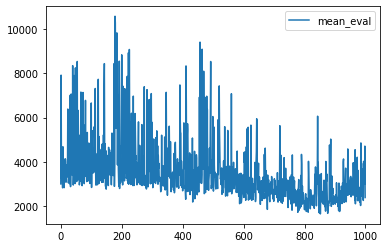

In [ ]:
logger_df = logger.to_dataframe()
logger_df.to_csv('../evo_logger_avoid.csv')
#logger_df = pd.read_csv('./evo8_logger.csv')
logger_df = logger_df.groupby(np.arange(len(logger_df))).mean()
#logger.to_dataframe().plot(y='mean_eval', logy=True)
logger_df.plot(y='mean_eval')

<AxesSubplot:>

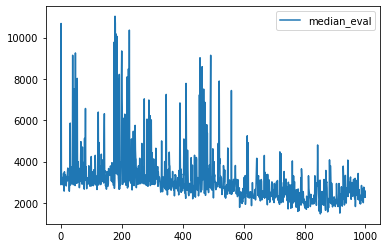

In [ ]:
logger_df.plot(y='median_eval')

<AxesSubplot:>

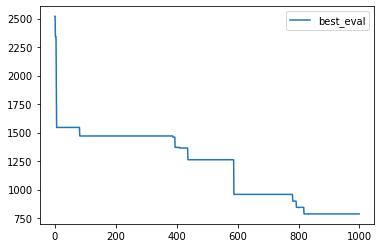

In [ ]:
logger_df.plot(y='best_eval')

#### Get Network with parameters according to trained model

In [ ]:
searcher.status

<LazyStatusDict
    center = tensor([ 2.3046e-01,  2.1050e-01, -1.4177e+00, -7.9738e-01, -2.5140e+00,
        -1.2152e+00, -3.3118e-01,  7.9815e-01, -1.6764e+00, -2.4041e-01,
        -9.5437e-01, -8.2161e-01,  1.2248e+00,  4.7938e-01, -2.4867e+00,
        -1.8560e+00, -1.3146e+00,  6.7498e-01, -1.7226e+00,  1.1372e+00,
        -1.5743e+00, -1.0057e+00,  1.2988e+00,  1.8048e+00, -1.9564e+00,
        -2.4515e+00, -2.7657e-02, -3.3268e+00,  3.7694e-01,  4.5840e-01,
        -8.6481e-01,  1.3036e+00, -1.4169e+00,  1.2120e+00,  2.1998e-01,
         7.1771e-01,  8.1205e-01, -7.1588e-01, -1.0290e+00, -2.0349e-01,
         8.2314e-01, -6.2375e-01, -8.9537e-02, -1.7480e-01,  4.6070e-01,
         1.5562e+00, -9.8488e-01, -2.9541e-01, -1.2233e+00, -1.7416e-01,
        -1.5444e+00,  1.3298e+00,  1.0477e-01,  4.3054e-01,  7.9032e-01,
        -7.8334e-01, -1.0005e+00, -5.6375e-01, -1.4211e-02,  2.9575e-01,
        -1.6478e-01,  1.1108e-01, -6.3693e-01, -2.9691e+00,  5.2612e-01,
         4.3501e-03, -

In [ ]:
trained_network = problem.parameterize_net(searcher.status['center'])
#save model
torch.save(trained_network.state_dict(), 'models/evo_avoid.pth')
#trained_network.load_state_dict(torch.load('models/evo5.pth'))

In [ ]:
#trained_network = problem.parameterize_net(searcher.status['best'])
#torch.save(trained_network.state_dict(), 'models/evo5_best.pth')

In [ ]:
#trained_network.load_state_dict(torch.load('models/evo_best.pth'))
#trained_network.load_state_dict(torch.load('models/evo_best_2.pth'))
#trained_network.load_state_dict(torch.load('models/evo8_legal.pth'))
trained_network.load_state_dict(torch.load('models/evo10.pth'))

<All keys matched successfully>

#### Use Model

living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tensor(13.)
living:  tens

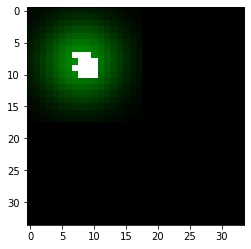

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from IPython.display import display, HTML
import IPython

state = generator.generate_moving_state(1, batch_size)

def extract_data(cell, target, food):
    if toxic:
        scent = trained_network.perceive_toxic(food)
    else:
        scent = trained_network.perceive_scent(food)
    green = np.minimum(scent[0] + food[0], 1)
    #blue += cell[0, 0]
    green = np.minimum(green+cell[0,0], 1)
    #im = np.stack([food[0], cell[0, 0], np.zeros(shape=(34, 34))])
    #im = np.stack([food[0], cell[0, 0], scent[0]])
    im = np.stack([cell[0,0], green, cell[0,0]])

    #im = im.transpose(axes=(0, 2))
    im = (torch.tensor(im).transpose(0, 2)).cpu().detach().numpy()
    #row1 = np.hstack((cell[0, 0].detach().cpu().numpy(), target[0]))
    return im

@torch.no_grad()
def animate(i):
    torch.set_printoptions(threshold=100000)
    torch.set_printoptions(precision=1)
    global cell
    global target
    global food
    global food_coord
    mat.set_data(extract_data(cell, target, food)) 
    living = trained_network.living_cells_above(cell[:, 0:1], 0.1)
    print('living: ', living[0])
    #print('before mask: ', (cell[0, 0] >= 0.1).to(torch.float).sum())
    #print('after keep_k: ', (trained_network.keep_k_largest(cell, living)[0,0] >= 0.1).to(torch.float).sum())
    cell, food, live_count, _ = trained_network(cell, food, 1)
    #print('living after: ', trained_network.living_cells_above(cell[:, 0:1], 0.1)[0])

    #print((cell > 1.1).to(torch.float).sum()) # this shows the potential importance of including clamp
    #print('live_count: ', live_count[0].item())
    if i % 2 == 0:
        target = generator.move_towards_food(target, food_coord)
        #print(target.sum(dim=(1,2)))


cell = torch.tensor(state.x, device=device)
food = torch.tensor(state.food, device=device).clone()
#food[0] = 0.0
#food[0, 3, 14] = 1.0
#food[0, 26, 14] = 1.0
#food[0, 14, 25] = 1.0
#food[0, 14, 6] = 1.0
#food[0, 24, 24] = 1.0
target = state.x[:, 0]
food_coord = generator.get_food_coord_from_food(state.food)
fig, ax = plt.subplots()

#mat = ax.imshow(extract_data(cell, target, food), cmap='gray')
mat = ax.imshow(extract_data(cell, target, food))
#mat = ax.matshow(extract_data(cell, target), cmap='gray')

def init_animate():
    mat.set_data(extract_data(cell, target, food)) 
    #ax.matshow(extract_data(cell, target), cmap='gray')

def save_video(video_data):
    name = 'videos/evo10_3.html'
    with open(name, 'w') as f:
        f.write(video_data)

video = IPython.display.HTML(animation.FuncAnimation(fig, animate, init_func=init_animate, frames=50, interval=150).to_jshtml())
save_video(video.data)
#video = IPython.display.HTML(animation.FuncAnimation(fig, animate, frames=50, interval=150).to_jshtml())
video

In [ ]:
network = trained_network
#state = generator.generate_moving_state(50, batch_size)
batch = generator.generate_ca_and_food(batch_size)
#cell = torch.tensor(state.x, dtype=dtype_of(trained_network), device=device)
#food = torch.tensor(state.food, dtype=dtype_of(trained_network), device=device)

cell = torch.tensor(batch, dtype=dtype_of(network), device=device_of(network))
food = torch.tensor(batch[:, 3], dtype=dtype_of(network), device=device_of(network))

#print(food1 == food)

#target = state.x[:, 0]
#food_coord = generator.get_food_coord_from_food(state.food)

In [ ]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>